## Try using the phase difference between EW and st_vel as a filter

: does not work because of the lost of spacial info

In [44]:
from cgi import test
from tkinter import EW
import numpy as np
import cv2
import scipy as scipy
import matplotlib.pyplot as plt
from astropy.io import fits
import polarTransform
from marvin.tools import Maps
from scipy.fft import fft, fftfreq

In [2]:
# Find the nth occurance to resolve the repetition of '-'
# For later use
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

In [3]:
def normalize(arr, t_min = 0, t_max = 1):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)    
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

In [7]:
def polarize(array, plotimage = False):
    h = array.shape[0]
    w = array.shape[1]
    
    mean = np.mean(array)
    sd = np.std(array)

    sigma_lw = mean - 1 * sd
    sigma_up =  mean + 1 * sd
    
    polarImage, ptSettings = polarTransform.convertToPolarImage(array, center=[round(w/2), round(h/2)])
    
    if plotimage == True:
        plt.imshow(polarImage.T, origin='upper', cmap='viridis',vmin=sigma_lw, vmax=sigma_up)
        plt.gca().invert_yaxis()
        plt.colorbar(orientation='vertical')
        plt.show()
    else:
        return polarImage.T

In [26]:
def dimen_reduc(array, sig = 2, smooth = 10):
    COL = [sum(x)/array.shape[0] for x in zip(*array)]
    # Exclude outlier using 3-sigma variant
    mean = np.mean(COL)
    sd = np.std(COL)
    CLEAN = [x for x in COL if (x >= mean - sig * sd)]
    CLEAN = [x for x in CLEAN if (x <= mean + sig * sd)]
    # Smoothening the curve using Gaussian filter
    SMO = scipy.ndimage.gaussian_filter(CLEAN, sigma = smooth)
    norm = normalize(SMO)

    # Make them all to the same length through interpolation
    x = np.linspace(0,len(norm),len(norm))
    y = norm
    x2 = np.linspace(0,len(norm),500)
    f_linear = scipy.interpolate.interp1d(x, y)
    intp = f_linear(x2)
    return intp

In [33]:
def repeat_cycle(array,  cycle = 2, line_up = False, method = 'max'):
    # To better identify the feature, plot cycles of the galaxy
    rp_list= []
    for i in range(0, cycle+1):
        rp_list = rp_list + list(array)
        
    if line_up == True:
        # Plot certain cycles
        if method == 'max':
            # limited the array to N cycles: but from max to max
            max_index = max(rp_list, default = 0) # find max value
            start_index = [i for i, n in enumerate(rp_list) if n == max_index][0] # find index of 1st max
            end_index = [i for i, n in enumerate(rp_list) if n == max_index][cycle] # find index of nth max
            trunc_list = np.array(rp_list[start_index:end_index]) # truncate from 1st to nth max
        elif method == 'min':
            # limited the array to N cycles: but from max to max
            min_index = min(rp_list, default = 0) # find min value
            start_index = [i for i, n in enumerate(rp_list) if n == min_index][0] # find index of 1st min
            end_index = [i for i, n in enumerate(rp_list) if n == min_index][cycle] # find index of nth min
            trunc_list = np.array(rp_list[start_index:end_index]) # truncate from 1st to nth min
        else:
            pass

        # Correct the 0 data error first:
        if len(trunc_list) <= 4:
            trunc_list = np.linspace(0,200,500)
        else:
            pass
    else:
        trunc_list = rp_list
    
    return np.array(trunc_list)

In [34]:
plateifu = "7990-1901"

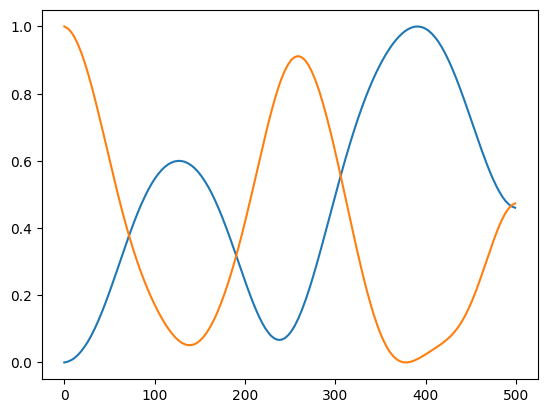

In [49]:

maps = Maps(plateifu, bintype='SPX', template='MILESHC-MASTARSSP')

oiii_ew = maps.emline_gew_oiii_5008.value
st_vel = abs(maps.stellar_vel.value)


red_vel = dimen_reduc(repeat_cycle(polarize(st_vel), cycle = 4), smooth = 8)
red_oiii = dimen_reduc(repeat_cycle(polarize(oiii_ew), cycle = 4), smooth = 8)

plt.plot(red_vel)
plt.plot(red_oiii)
plt.show()



In [ ]:
# create fake data
nsr = 1e-1
r = np.random.normal(size=(20000,2)) * nsr
phdiff = math.pi * np.random.uniform()
print('true phase diff (radians):', phdiff, '\t(degrees):', phdiff / (2 * math.pi) * 360)
omega = 13.56e6
t = np.arange(20000) / 500e6
rdata = np.zeros((len(t), 2))
ph0 = 2 * math.pi * np.random.uniform()
rdata[:,0] = np.sin(2 * math.pi * omega * t + ph0)
rdata[:,1] = np.sin(2 * math.pi * omega * t + phdiff + ph0)
rdata = rdata + r

# scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rdata)
data = scaler.transform(rdata)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(data[1:100,:])
plt.show()

# phase difference determination
plt.figure(figsize=(4,4))
plt.title('Phase diagram')
plt.scatter(data[1:100,0],data[1:100,1])
plt.show()

c = np.cov(np.transpose(data))
print('cov: ', c)
phi = np.arccos(c[0,1] )
print('phase estimate (radians): ', phi, '(degrees): ', phi / math.pi * 180)

In [46]:
x = np.linspace(0, 500, 500)

wave_vel = red_vel
yf_vel = np.abs(fft(wave_vel-0.5)[0:50])

wave_ew = red_oiii
yf_ew = np.abs(fft(wave_ew-0.5)[0:50])

# Where is a 200 Hz frequency in the results?
freq = np.fft.fftfreq(x.size, d=1)
index, = np.where(np.isclose(freq, 4, atol=1/(500)))

# Get magnitude and phase
magnitude = np.abs(yf[index[0]])
phase = np.angle(yf[index[0]])
print("Magnitude:", magnitude, ", phase:", phase)


plt.plot(yf_vel)
plt.plot(yf_ew)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

Magnitude: 44.805875391277276 , phase: -0.2672456406675483


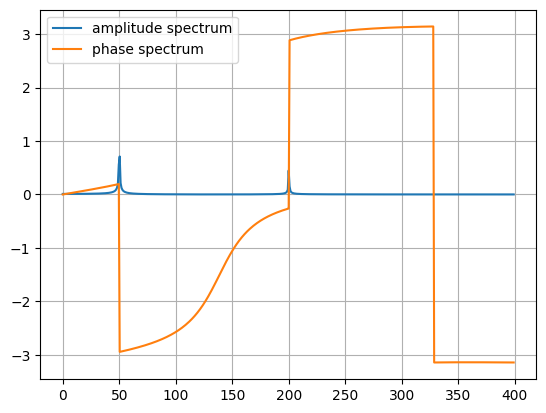

In [29]:
# Number of sample points
N = 1000

# Sample spacing
T = 1.0 / 800.0     # f = 800 Hz

# Create a signal
x = np.linspace(0.0, N*T, N)
t0 = np.pi/6   # non-zero phase of the second sine
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(200.0 * 2.0*np.pi*x + t0)
yf = np.fft.fft(y) # to normalize use norm='ortho' as an additional argument

# Where is a 200 Hz frequency in the results?
freq = np.fft.fftfreq(x.size, d=T)
index, = np.where(np.isclose(freq, 200, atol=1/(T*N)))

# Get magnitude and phase
magnitude = np.abs(yf[index[0]])
phase = np.angle(yf[index[0]])
print("Magnitude:", magnitude, ", phase:", phase)

# Plot a spectrum 
plt.plot(freq[0:N//2], 2/N*np.abs(yf[0:N//2]), label='amplitude spectrum')   # in a conventional form
plt.plot(freq[0:N//2], np.angle(yf[0:N//2]), label='phase spectrum')
plt.legend()
plt.grid()
plt.show()

In [ ]:




# Correct the 0 data error first:
if len(trunc_EW) <= 4:
    trunc_EW = np.linspace(0,200,200)
else:
    pass
# Normalization 
norm_EW = normalize(trunc_EW)

# Make them all to the same length through interpolation
x = np.linspace(0,len(norm_EW),len(norm_EW))
y = norm_EW
x2 = np.linspace(0,len(norm_EW),500)
f_linear = scipy.interpolate.interp1d(x, y)
intp_EW = f_linear(x2)


return intp_EW, plateifu

In [ ]:
def fourier_classifier(sample):
    
    # Importing data, use 2 cycles(default)
    test_EW_hist = sample[0]
    test_plateifu = sample[1]

    # 1. Set curve osillate around  y=0
    # 2. Take the FT result from 1~50(not 0~50) because FT saturate at 0. 
    # Fourier Transform:
    yf = np.abs(fft(test_EW_hist-0.5)[1:50])
    
    # Return the stongest frequency
    max_index = list(yf).index(max(yf))
    # Compensate the step 2.
    max_corr = max_index + 1
    
    # Find the 4 largest peak value
    yf.sort()
    loss = sum(np.diff(yf[-4:]))
    
    return max_corr, loss, test_plateifu